In [1]:
import _nb_utils
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from data import *
from utils import *
from color_map import apply_colormap, COLOR_MAP_DICT
from functools import partial
from collections import OrderedDict

from torch import nn
from torchvision.transforms.functional import to_pil_image
from torchvision.models import segmentation as segmodels
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights, MobileNetV3
from torchvision.transforms._presets import SemanticSegmentation
from torchvision.utils import draw_segmentation_masks

In [3]:
IMAGE_SIZE = 520

In [4]:
ds = SegDataset(image_UIDs, IMAGE_SIZE, CLASS_MAP)

In [5]:
model = segmodels.lraspp_mobilenet_v3_large(
    # weights=None, # initialised decoder
    weights=segmodels.LRASPP_MobileNet_V3_Large_Weights.DEFAULT, # pre-trained decoder
    weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V2 # pre-trained backbone
)
model.to(CONFIG["device"])
model.eval()

preprocess = partial(SemanticSegmentation, resize_size=IMAGE_SIZE)() # same as default transforms, but resize to 224 (instead of 520), as original backbone is trained on 224x224 ImageNet pictures.

In [6]:
model.backbone.requires_grad_(False)
model.classifier.requires_grad_(True);

In [7]:
collate_fn = partial(extract_augment_preprocess_batch, augment_fn=None, preprocess_fn=preprocess)

In [8]:
lr = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [9]:
B = 16
T = 10 # num. epochs

In [10]:
dl = DataLoader(
    ds,
    batch_size=B,
    shuffle=True,
    generator=torch_gen,
    collate_fn=collate_fn,
    # pin_memory=True,
    # num_workers=0
)

In [11]:
# TODO assert complete data reproducility
# TODO handle metrics
# TODO speed up things
# TODO refactor everything
# TODO structure the output in the best way.
# TODO check if the pre-processing can in be coded better.
# MODEL = torch.compile(MODEL) # only works if COMPUTE_CAPABILITY > 7.0

alpha = 0.95 # running loss smoothing factor

print(f"- Train. data-loader of {len(dl)} mini-batches of size {B}")
display(Markdown("---"))

for epoch in range(T):

    running_loss = None
    progress_bar = tqdm(dl, desc=f"Epoch {epoch+1}/{T}")

    for step, (scs, gts) in enumerate(progress_bar):

        t0 = time.time()

        model.train()

        scs = scs.to(CONFIG["device"])
        gts = gts.to(CONFIG["device"])

        optimizer.zero_grad()

        logits = model(scs)
        logits = logits["out"] if isinstance(logits, OrderedDict) else logits

        batch_loss = criterion(logits, gts)
        batch_loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients
        optimizer.step()

        postfixes = {}
        postfixes["loss"] = f"{batch_loss:4f}"
        postfixes["lr"] = f"{lr:4.2e}"
        postfixes["grad_norm"] = f"{grad_norm:4.2f}"

        progress_bar.set_postfix(postfixes)

        torch.cuda.synchronize() if CONFIG["device"] == "cuda" else None
        dt = (time.time() - t0)*1000 # delta-time in ms

display(Markdown("---"))

- Train. data-loader of 183 mini-batches of size 16


---

Epoch 10/10: 100%|██████████| 183/183 [02:47<00:00,  1.10it/s, loss=1.535839, lr=1.00e-04, grad_norm=4.18]


---

## Inference

In [12]:
idxs = range(0, 10)
img_paths_to_upload = image_UIDs[idxs]

sc_list = [get_sc(SCS_PATH / (img_path + ".jpg"), IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]
gt_list = [get_gt(GTS_PATH / (img_path + ".png"), CLASS_MAP, IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]

In [13]:
scs = torch.stack(sc_list, dim=0)
gts = torch.stack(gt_list, dim=0)
scs.shape, gts.shape

(torch.Size([10, 3, 520, 520]), torch.Size([10, 1, 520, 520]))

In [14]:
X = preprocess(scs)
logits = model(X)["out"]
prs = logits.argmax(dim=1, keepdim=True).float()
assert scs.shape[2:] == gts.shape[2:] == prs.shape[2:]
prs.shape

torch.Size([10, 1, 520, 520])

In [15]:
gts_all_classes = (gts[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
prs_all_classes = (prs[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
assert prs_all_classes.shape == gts_all_classes.shape
gts_all_classes.shape

torch.Size([10, 21, 520, 520])

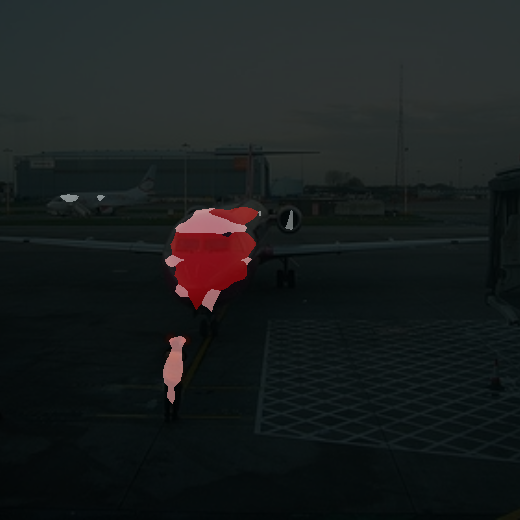

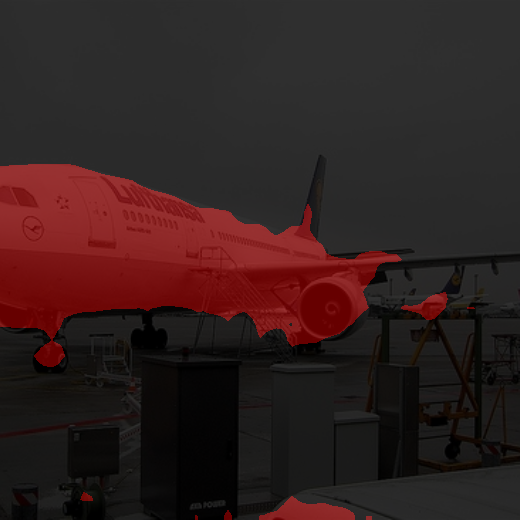

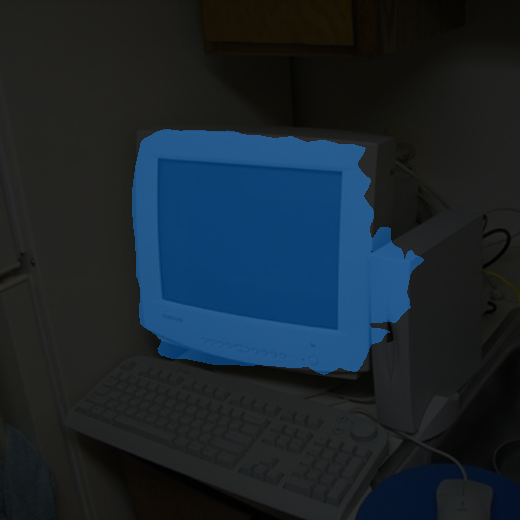

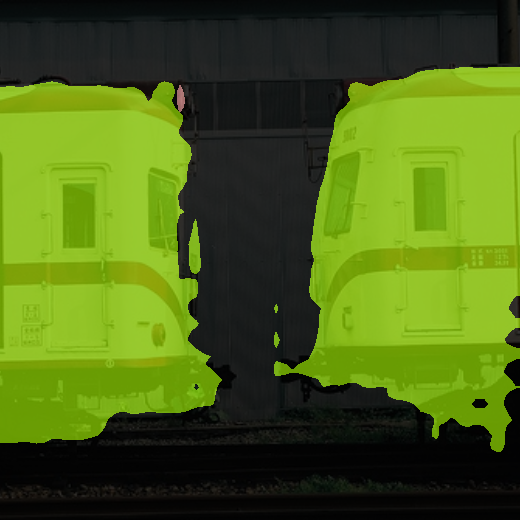

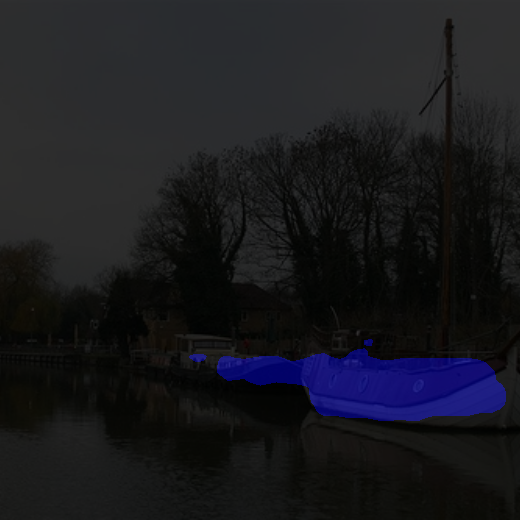

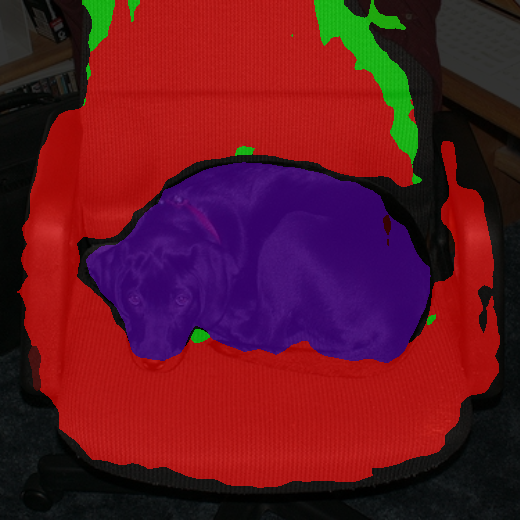

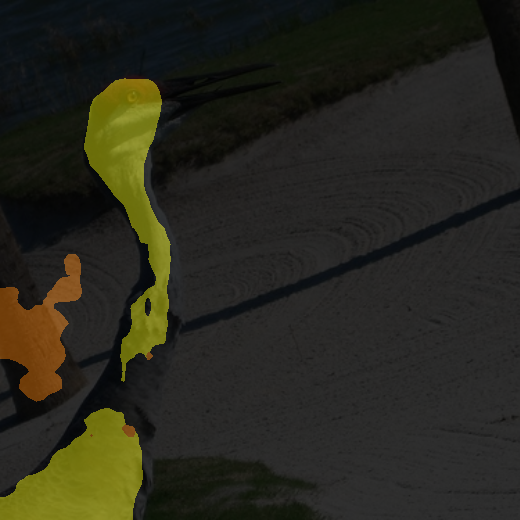

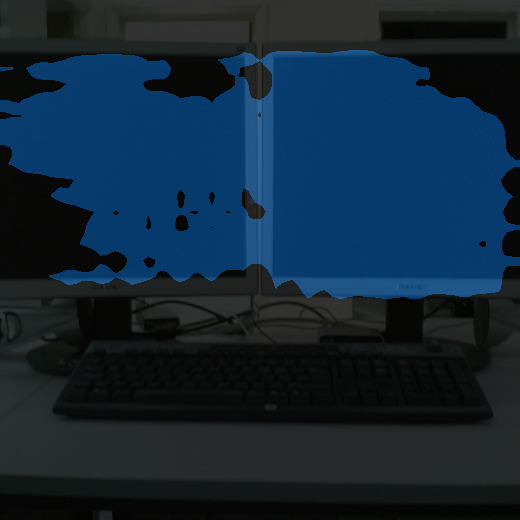

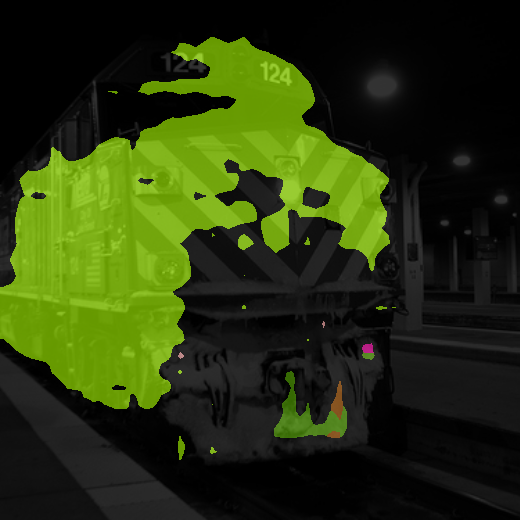

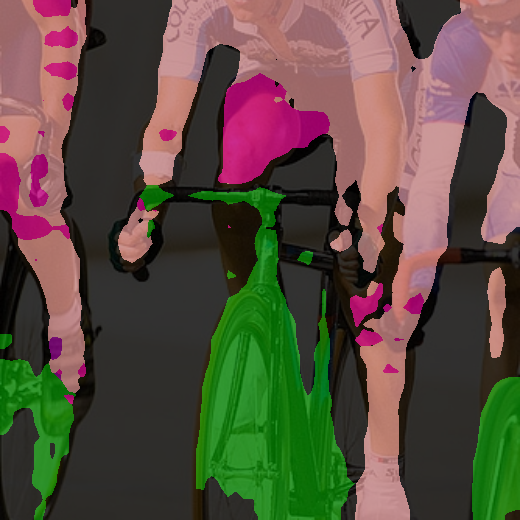

In [16]:
for i, idx in enumerate(idxs):
    pr_ovr = draw_segmentation_masks(scs[i], prs_all_classes[i], colors=list(COLOR_MAP_DICT.values()))
    display(to_pil_image(pr_ovr))
    # torchvision.utils.save_image(prs[i], mask_prs_path / f"mask_pr_{idx}.png", value_range=(0, 255), normalize=True)